In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

linear2db = lambda x: 10*np.log10(x) 
db2linear = lambda x: np.power(10,x/10)

samples = 2000

In [2]:
class antenna:
    def __init__(self, λ, d, N, w, shift = 0):
        self.λ = λ            # Wave length
        self.d = d            # Distance between 2 antennas
        self.N = N            # Num of antennas in the array
        self.w = w            # Weights by hamming
        self.shift = shift
        
        #self.gain = np.roll(self.GetGain(oneSide = True, db = True), samples//2)[samples//4:3 * samples//4]
        
    def GetGain(self, db = True, shift = None, oneSide = False):
        k = 2 * np.pi / np.abs(self.λ)
        locations = np.arange(self.N) * self.d
        
        gain = np.zeros(samples)
        phis = np.linspace(0,2*np.pi,samples)
        
        if shift:
            beta = np.arange(self.N) * np.deg2rad(shift)
        else:
            beta = np.arange(self.N) * np.deg2rad(self.shift)
        
        for index, phi in enumerate(phis):
            gain[index] = np.sum(self.w * np.exp(1j * beta) * np.exp(locations * -1j * k * np.sin(phi))) #Compute per phi
            
            
        if db:
            gain = linear2db(np.abs(gain) ** 2) # Convert to db and the antenna power
        else:
            gain = np.abs(gain) ** 2
            
        if oneSide:
            gain[samples//4: 3*samples//4] = np.min(gain)
    
        return np.clip(gain,-np.inf,np.inf)     # Boundaries


    def GetBeamWidth(self):
        gain = np.roll(self.GetGain(shift = 0, db = False),samples//2)
        hp = np.max(gain) / 2
        
        r = len(gain)//2
        l = r-1
        
        while gain[l] >= hp and gain[r] >= hp:
            r, l = r+1, l-1 
                
        return np.abs(r - l)
    
    
    def HPBW(self,gain):
        maxPowerIndex = np.argmax(gain)
        HalfPower = np.max(gain)//2
        l, r = maxPowerIndex - 1, maxPowerIndex + 1 
        while gain[l] > HalfPower and gain[r] > HalfPower:
            l,r = l-1, r+1
            
        return np.abs(l - r) 
    
    def BW(self, gain):
        
        # Return the FPBW by the first min point after the max power
        return (find_peaks(-gain)[0][find_peaks(-gain)[0] > samples//4][0] - samples//4) * 0.36
        
        # Return the HPBW by the first point which smaller than maxPower/2
        #return np.argmax(np.split(gain,2)[1] < np.max(gain)//2) * 0.36
        
        # Return the HPBW by the first point which smaller than maxPower - 3db
        #return np.argmax(np.split(gain,2)[1] < np.max(gain) - 3) * 0.36 
    
    def maxSideLobe(self, gain):
        i = np.argmax(gain)
        
        while gain[i] >= gain[i + 1]:
            i += 1
        return np.max(gain[i:])
    
    def maxPower(self,gain):
        return np.max(gain)
    
    def MainSideRatio(self, gain):
        sorted_peaks = np.sort(gain[find_peaks(gain)[0]])
        MaxPower, MaxSidelobe = sorted_peaks[-1], sorted_peaks[-2]
        if MaxPower == 0:
            MaxPower = np.finfo(np.float32).eps
        return MaxSidelobe/MaxPower
    
    
class genetic:
    def __init__(self, PN, GN, PC, PM, N = 80, shift = 0, λ = 1):
        
        self.PN = PN # Population Number
        self.GN = GN # Generations Number
        self.PC = PC # Probability of crossover
        self.PM = PM # Probality of mutation
        
        self.antennaParam = {"N": N,
                             "shift": shift,
                             "λ": λ,
                             "d": λ*0.5}
        
        self.population = np.random.choice([0, 1], size=(PN, N), p= [0.2,0.8])
        
    def Crossover(self ,arr):   
        r,c  = arr.shape
        assert r%2 == 0 and c%2 == 0
        i1, i2 = arr[:r//2, :].copy(), arr[r//2:, :].copy()
        temp = i2[:,c//2:].copy()
        i2[:,c//2:], i1[:,c//2:] = i1[:,c//2:], temp
        return np.concatenate((i1, i2), axis=0)
    
    def Mutation(self, i):
        if np.random.rand() < self.PM:
            x = np.random.randint(0, len(i), np.random.randint(0,20))
            i[x] = 1 - i[x]
        return i
    
    def Fitness(self, w):
        Ant = antenna(λ = self.antennaParam["λ"],
                      d = self.antennaParam["d"], 
                      N = self.antennaParam["N"],
                      w = w,
                      shift = self.antennaParam["shift"])
        
        gain = np.roll(Ant.GetGain(db = False, oneSide = True),samples//2)[samples//4:3 * samples//4]
        
        fit =  Ant.BW(gain) + Ant.MainSideRatio(gain) #+ 0.1* np.sum(w)/len(w) # + np.finfo(np.float32).eps
        
        
        
        if np.sum(w)/len(w) < 0.65 or np.sum(w)/len(w) > 0.8 or Ant.MainSideRatio(gain) > 0.1:
            fit += 1000.0

        return fit
        
    
    def Selection(self, fitness):
        top10 = np.argsort(fitness)[:int(self.PN * 0.1)]
        
        low90 = np.argsort(fitness)[int(self.PN * 0.1):]
        fitness90 = fitness[low90]
        
        if np.all(fitness90 == fitness90[0]):
            return np.concatenate((top10, low90[np.random.choice(len(fitness90) , size=len(fitness90), replace=True, p = fitness90 / np.sum(fitness90))]))
        
        fitness90 = np.max(fitness90) - fitness90
        fitness90 /= np.sum(fitness90)
        
        return np.concatenate((top10, low90[np.random.choice(len(fitness90) , size=len(fitness90), replace=True, p = fitness90)]))
    
    def Step(self):
        fitness = np.apply_along_axis(self.Fitness , 1, self.population)
        
        #### Get the top soultion and it's fitness ####
        minimum = np.min(fitness)
        top = self.population[np.argmin(fitness)]
        
        ### Normalize to probalties ###
        fitness = fitness / np.sum(fitness)
        
        ### Selection ###
        selected = self.Selection(fitness)
        self.population = self.population[selected]
        
        ### Cross-over ###
        if np.random.rand() < self.PC:
            self.population[int(self.PN*0.1):] = self.Crossover(self.population[int(self.PN*0.1):])
            
        ### Mutation ####    
        self.population[int(self.PN*0.1):] = np.apply_along_axis(self.Mutation,1 ,self.population[int(self.PN*0.1):])
        
        return minimum, top
    
    def plot(self, minimumArray, title1, top, title2 = ""):
        Ant = antenna(λ = self.antennaParam["λ"],
                      d = self.antennaParam["d"], 
                      N = self.antennaParam["N"],
                      w = top,
                      shift = self.antennaParam["shift"])
        
        FullAnt = antenna(λ = self.antennaParam["λ"],
                          d = self.antennaParam["d"], 
                          N = self.antennaParam["N"],
                          w = np.ones(self.antennaParam["N"]),
                          shift = self.antennaParam["shift"])
        
        gain1 = np.roll(FullAnt.GetGain(oneSide = True, db = True), samples//2)[samples//4:3 * samples//4]
        gain2 = np.roll(Ant.GetGain(oneSide = True, db = True), samples//2)[samples//4:3 * samples//4]
        
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
        
        axs[0].set_title(title1)
        axs[0].plot(minimumArray)
        axs[0].grid()
        
        axs[1].set_title(f"BW: {Ant.BW(db2linear(gain2))}, Ratio: {Ant.MainSideRatio(db2linear(gain2))}")
        axs[1].plot(gain1 - np.max(gain1))
        axs[1].plot(gain2 - np.max(gain2))
        
        axs[2].imshow(top.reshape(1,len(top)), cmap='binary', interpolation='nearest')
        axs[2].set_title(f"{np.sum(top)/len(top):.2f}%")
        axs[2].set_yticklabels([])
        
        plt.show()
    
    def Run(self):
        minimumArray = []
        for i in range(self.GN):
            clear_output(wait=True)
            minimum, top = self.Step()
            minimumArray.append(minimum)
            
            self.plot(minimumArray, f"Generation {i+1}/{self.GN}:",top,f"Minmum fitness {minimum:.4f}.")
            
        return top
        

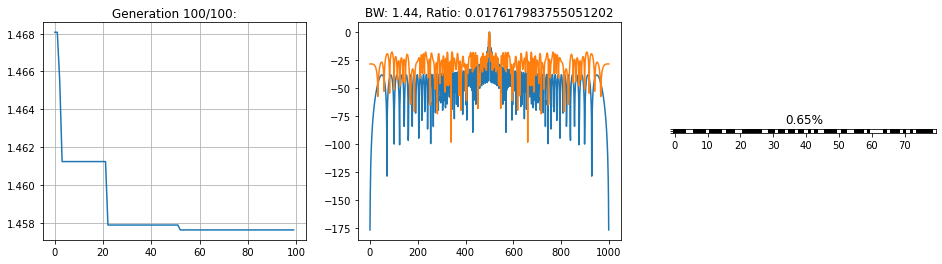

In [3]:
%matplotlib inline

## Array features ###

λ = 1                 # Wave length                            
N = 80                # Num of antennas in the array
shift = 0             # Phase shift in degrees

### Population features ###

PN = 100            
GN = 100            
PC = 1.0            
PM = 0.5            


Genetic = genetic(PN = PN, GN = GN, PC = PC, PM = PM, λ = λ, N = N, shift = shift)
top = Genetic.Run()

Top 34.32006687269598 16.779628924716807 0.48891597405558024
Full 38.06179973983887 24.287251761819327 0.6381004557805533


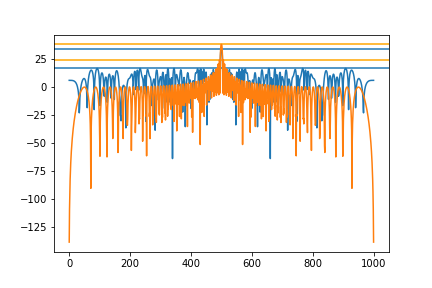

In [6]:
%matplotlib widget

Ant = antenna(λ = λ, d = λ* 0.5, N = N, w = top, shift = 0)

FullAnt = antenna(λ = λ, d = λ* 0.5,  N = N, w = np.ones(N), shift = 0)

gain1 = np.roll(FullAnt.GetGain(oneSide = True, db = True), samples//2)[samples//4:3 * samples//4]
gain2 = np.roll(Ant.GetGain(oneSide = True, db = True), samples//2)[samples//4:3 * samples//4]

#gain1 /= np.max(gain1)
#gain2 /= np.max(gain2)

peaks, _ = find_peaks(gain2)
sorted_peaks = sorted(peaks, key=lambda x: gain2[x], reverse=True)
highest_peaks = sorted_peaks[:2]
peak_values = gain2[highest_peaks]

plt.axhline(y = peak_values[0])
plt.axhline(y = peak_values[1])
print("Top",peak_values[0], peak_values[1], peak_values[1]/peak_values[0])
plt.plot(gain2)

peaks, _ = find_peaks(gain1)
sorted_peaks = sorted(peaks, key=lambda x: gain1[x], reverse=True)
highest_peaks = sorted_peaks[:2]
peak_values = gain1[highest_peaks]

plt.axhline(y = peak_values[0], color = "orange")
plt.axhline(y = peak_values[1], color = "orange")
print("Full",peak_values[0], peak_values[1], peak_values[1]/peak_values[0])
plt.plot(gain1)

plt.show()